# Example 5: NPTF Correction for the Point Spread Function (PSF)

In this example we show how to account for the PSF correction using `psf_correction.py`

Fundamentally the presence of a non-zero PSF implies that the photons from any point source will be smeared out into some region around its true location. This effect must be accounted for in the NPTF. This is achieved via a function $\rho(f)$. In the code we discretize $\rho(f)$ as an approximation to the full function.

The two outputs of an instance of `psf_correction` are: 1. f_ary, an array of f values; and 2. df_rho_div_f_ary, an associated array of $\Delta f \rho(f)/f$ values, where $\Delta f$ is the width of the f_ary bins.

If the angular reconstruction of the data is perfect, then $\rho(f) = \delta(f-1)$. In many situations, such as for the _Fermi_ data at higher energies, a Gaussian approximation of the PSF will suffice. Even then there are a number of variables that go into evaluating the correction, as shown below. Finally we will show how the code can be used for the case of non-Gaussian PSFs.

As the calculation of $\rho(f)$ can be time consuming, we always save the output to avoid recomputing the same correction twice. Consequently it can be convenient to have a common `psf_dir` where all PSF corrections for the runs are stored.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from NPTFit import psf_correction as pc # Module for determining the PSF correction

from __future__ import print_function

## Example 1: Default Gaussian PSF

We start by showing the PSF correction for a Gaussian PSF - that is the PSF as a function of $r$ is $\exp \left[ -r^2 / (2\sigma^2) \right]$ - with $\sigma$ set to the value of the 68% containment radius for the PSF of the _Fermi_ dataset we will use in later examples.

Loading the psf correction from: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy
f_ary: [ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]
df_rho_div_f_ary: [ 65.21947121   6.86206661   2.51497456   1.29484993   0.810835     0.5349215
   0.09643067   0.           0.           0.        ]


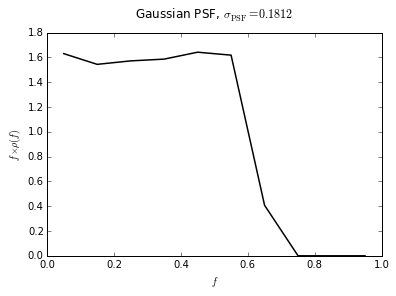

In [2]:
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary_1 = pc_inst.f_ary
df_rho_div_f_ary_1 = pc_inst.df_rho_div_f_ary

print('f_ary:', f_ary_1)
print('df_rho_div_f_ary:', df_rho_div_f_ary_1)

plt.plot(f_ary_1,f_ary_1**2*df_rho_div_f_ary_1/(f_ary_1[1]-f_ary_1[0]),color='black', lw = 1.5)
plt.xlabel('$f$')
plt.ylabel('$f \\times \\rho(f)$')
plt.title('Gaussian PSF, $\sigma_\mathrm{PSF} = 0.1812$', y=1.04)

## Example 2: Impact of changing $\sigma$

Here we show the impact on the PSF of changing $\sigma$. From the plot we can see that for a small PSF, $\rho(f)$ approaches the no PSF case of $\delta(f-1)$ implying that the flux fractions are concentrated at a single large value. As $\sigma$ increases we move away from this idealized scenario and the flux becomes more spread out, leading to a $\rho(f)$ peaked at lower flux values.

File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_128_0.05_10_50000_1000_0.01.npy
File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_128_0.4_10_50000_1000_0.01.npy


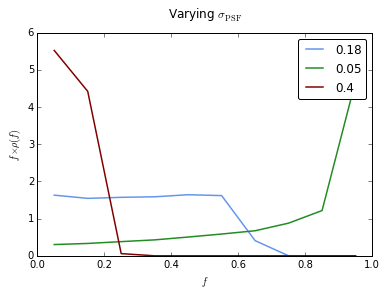

In [3]:
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.05)
f_ary_2 = pc_inst.f_ary
df_rho_div_f_ary_2 = pc_inst.df_rho_div_f_ary

pc_inst = pc.PSFCorrection(psf_sigma_deg=0.4)
f_ary_3 = pc_inst.f_ary
df_rho_div_f_ary_3 = pc_inst.df_rho_div_f_ary

plt.plot(f_ary_1,f_ary_1**2*df_rho_div_f_ary_1/(f_ary_1[1]-f_ary_1[0]),color='cornflowerblue',label='0.18', lw = 1.5)
plt.plot(f_ary_2,f_ary_2**2*df_rho_div_f_ary_2/(f_ary_2[1]-f_ary_2[0]),color='forestgreen',label='0.05', lw = 1.5)
plt.plot(f_ary_3,f_ary_3**2*df_rho_div_f_ary_3/(f_ary_3[1]-f_ary_3[0]),color='maroon',label='0.4', lw = 1.5)
plt.xlabel('$f$')
plt.ylabel('$f \\times \\rho(f)$')
plt.legend(loc='upper right', fancybox=True)
plt.title('Varying $\sigma_\mathrm{PSF}$', y=1.04)

## Example 3: Changing the default options for determining $\rho(f)$

In this example we show how for a given PSF, the other parameters associated with how accurately we calculate $\rho(f)$ can impact what we get back. The parameters that can be changed are are:

| Argument  | Defaults | Purpose |
| ------------- | ------------- | ------------- |
| `num_f_bins`  | 10 | number of f_bins used |
| `n_psf`  | 50000 | number of PSFs placed down when calculating |
| `n_pts_per_psf`  | 1000 | number of points to place per psf in the calculation |
| `f_trunc`  | 0.01 | minimum flux fraction to keep track of  |
| `nside`  | 128 | nside of the map the PSF is used on |

The default parameters have been chosen to be accurate enough for the Fermi analyses we will be performed later. But if the user changes the PSF (even just $\sigma$), it is important to be sure that the above parameters are chosen so that $\rho(f)$ is evaluated accurately enough.

In general increasing `num_f_bins`, `n_psf`, and `n_pts_per_psf`, whilst decreasing `f_trunc` leads to a more accurate $\rho(f)$. But each will also slow down the evaluation of $\rho(f)$, and in the case of `num_f_bin`, slow down the subsequent non-Poissonian likelihood evaluation.

`nside` should be set to the value of the map being analysed, but we also highlight the impact of changing it below. For an analysis on a non-HEALPix grid, the PSF can often be approximated by an appropriate HEALPix binning. If this is not the case, however, a different approach must be pursued in calculating $\rho(f)$.

File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_128_0.181_20_50000_1000_0.01.npy
File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_128_0.181_10_5000_100_0.01.npy
File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_128_0.181_10_50000_1000_0.1.npy
File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_64_0.181_10_50000_1000_0.01.npy


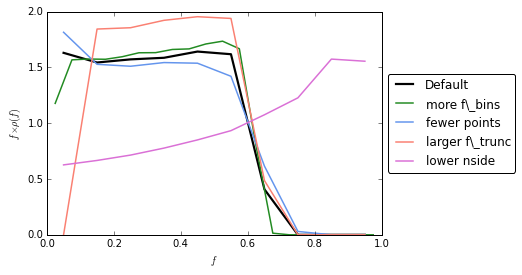

In [4]:
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812,num_f_bins=20)
f_ary_4 = pc_inst.f_ary
df_rho_div_f_ary_4 = pc_inst.df_rho_div_f_ary

pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812,n_psf=5000,n_pts_per_psf=100)
f_ary_5 = pc_inst.f_ary
df_rho_div_f_ary_5 = pc_inst.df_rho_div_f_ary

pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812,f_trunc=0.1)
f_ary_6 = pc_inst.f_ary
df_rho_div_f_ary_6 = pc_inst.df_rho_div_f_ary

pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812,nside=64)
f_ary_7 = pc_inst.f_ary
df_rho_div_f_ary_7 = pc_inst.df_rho_div_f_ary

plt.plot(f_ary_1,f_ary_1**2*df_rho_div_f_ary_1/(f_ary_1[1]-f_ary_1[0]),color='black',label=r'Default', lw=2.2)
plt.plot(f_ary_4,f_ary_4**2*df_rho_div_f_ary_4/(f_ary_4[1]-f_ary_4[0]),color='forestgreen',label=r'more f\_bins', lw = 1.5)
plt.plot(f_ary_5,f_ary_5**2*df_rho_div_f_ary_5/(f_ary_5[1]-f_ary_5[0]),color='cornflowerblue',label=r'fewer points', lw = 1.5)
plt.plot(f_ary_6,f_ary_6**2*df_rho_div_f_ary_6/(f_ary_6[1]-f_ary_6[0]),color='salmon',label=r'larger f\_trunc', lw = 1.5)
plt.plot(f_ary_7,f_ary_7**2*df_rho_div_f_ary_7/(f_ary_7[1]-f_ary_7[0]),color='orchid',label=r'lower nside', lw = 1.5)
plt.xlabel('$f$')
plt.ylabel('$f \\times \\rho(f)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

## Example 4: PSF on a Cartesian Grid

For some applications, particularly when analyzing smaller regions of the sky, it may be desirable to work with data on a Cartesian grid rather than a healpix map. Note generally for larger regions, in order to account for curvature on the sky a healpix pixelization is recommended. Code to convert from Cartesian grids to healpix can be found here: https://github.com/nickrodd/grid2healpix

In order to calculate the appropriate PSF correction for Cartesian maps the general syntax is the same, except now the `healpix_map` keyword should be set to `False` and the `pixarea` keyword set to the area in sr of each pixel of the Cartesian map.

As an example of this syntax we calculate the PSF correction on a Cartesian map that has pixels the same size as an `nside=128` healpix map, and compare the two PSF corrections. Note they are essentially identical.

File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_0.21_0.181_10_50000_1000_0.01.npy


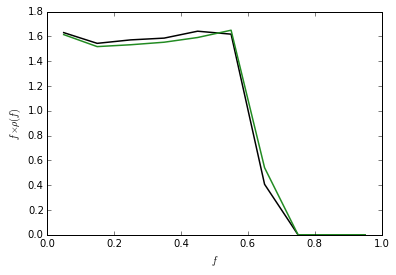

In [5]:
pixarea = 4*np.pi/(12*128*128)
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812, healpix_map=False, pixarea=pixarea)
f_ary_8 = pc_inst.f_ary
df_rho_div_f_ary_8 = pc_inst.df_rho_div_f_ary

plt.plot(f_ary_1,f_ary_1**2*df_rho_div_f_ary_1/(f_ary_1[1]-f_ary_1[0]),color='black', label=r'healpix', lw = 1.5)
plt.plot(f_ary_8,f_ary_8**2*df_rho_div_f_ary_8/(f_ary_8[1]-f_ary_8[0]),color='forestgreen', label=r'cartesian', lw = 1.5)
plt.xlabel('$f$')
plt.ylabel('$f \\times \\rho(f)$')

## Example 5: Custom PSF

In addition to the default Gausian PSF, `psf_correction.py` also has the option of taking in a custom PSF. In order to use this ability, the user needs to initialise `psf_correction` with `delay_compute=True`, manually define the parameters that define the PSF and then call `make_or_load_psf_corr`.

The variables that need to be redefined in the instance of `psf_correction` are:

| Argument  | Purpose |
| ------------- | ------------- |
| `psf_r_func`  | the psf as a function of r, distance in radians from the center of the point source |
| `sample_psf_max`  | maximum distance to sample the psf from the center, should be larger for psfs with long tails |
| `psf_samples`  | number of samples to make from the psf (linearly spaced) from 0 to sample_psf_max, should be large enough to adequately represent the full psf |
| `psf_tag`  | label the psf is saved with |

As an example of a more complicated PSF we consider the full Fermi-LAT PSF. The PSF of Fermi is approximately Gaussian near the core, but has larger tails. To model this a pair of King functions are used to describe the radial distribution. Below we show a comparison between the Gaussian approximation and the full PSF, for two different energies. As shown, for low energies where the Fermi PSF is larger, the difference between the two can be significant. For higher energies where the PSF becomes smaller, however, the difference is marginal.

For the full details of the Fermi-LAT PSF, see:
http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/IRF_PSF.html

File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_128_0.235_10_50000_1000_0.01.npy
File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/Fermi_PSF_2GeV.npy


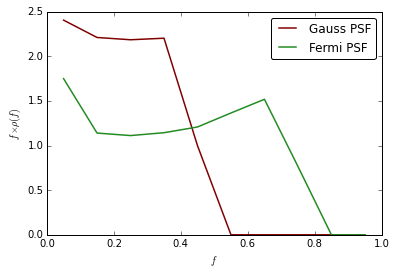

In [6]:
# Fermi-LAT PSF at 2 GeV

# Calculate the appropriate Gaussian approximation to the PSF for 2 GeV
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.2354)
f_ary_9 = pc_inst.f_ary
df_rho_div_f_ary_9 = pc_inst.df_rho_div_f_ary

# Define parameters that specify the Fermi-LAT PSF at 2 GeV
fcore = 0.748988248179
score = 0.428653790656
gcore = 7.82363229341
stail = 0.715962650769
gtail = 3.61883748683
spe = 0.00456544262478

# Define the full PSF in terms of two King functions
def king_fn(x, sigma, gamma):
    return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

def Fermi_PSF(r):
    return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

# Modify the relevant parameters in pc_inst and then make or load the PSF
pc_inst = pc.PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
pc_inst.psf_samples = 10000
pc_inst.psf_tag = 'Fermi_PSF_2GeV'
pc_inst.make_or_load_psf_corr()

# Extract f_ary and df_rho_div_f_ary as usual
f_ary_10 = pc_inst.f_ary
df_rho_div_f_ary_10 = pc_inst.df_rho_div_f_ary

plt.plot(f_ary_9,f_ary_9**2*df_rho_div_f_ary_9/(f_ary_9[1]-f_ary_9[0]),color='maroon',label='Gauss PSF', lw = 1.5)
plt.plot(f_ary_10,f_ary_10**2*df_rho_div_f_ary_10/(f_ary_10[1]-f_ary_10[0]),color='forestgreen',label='Fermi PSF', lw = 1.5)
plt.xlabel('$f$')
plt.ylabel('$f \\times \\rho(f)$')
plt.legend(loc='upper right', fancybox=True)

File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/gauss_128_0.055_10_50000_1000_0.01.npy
File saved as: /zfs/nrodd/NPTFitCodeDev/NPTFit/examples/psf_dir/Fermi_PSF_20GeV.npy


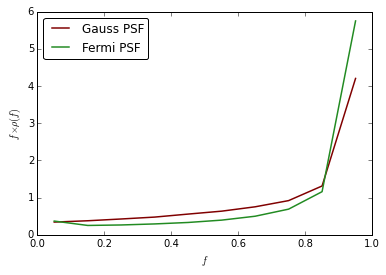

In [7]:
# Fermi-LAT PSF at 20 GeV

# Calculate the appropriate Gaussian approximation to the PSF for 20 GeV
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.05529)
f_ary_11 = pc_inst.f_ary
df_rho_div_f_ary_11 = pc_inst.df_rho_div_f_ary

# Define parameters that specify the Fermi-LAT PSF at 20 GeV
fcore = 0.834725201378
score = 0.498192326976
gcore = 6.32075520959
stail = 1.06648424558
gtail = 4.49677834267
spe = 0.000943339426754

# Define the full PSF in terms of two King functions
def king_fn(x, sigma, gamma):
    return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

def Fermi_PSF(r):
    return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

# Modify the relevant parameters in pc_inst and then make or load the PSF
pc_inst = pc.PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
pc_inst.psf_samples = 10000
pc_inst.psf_tag = 'Fermi_PSF_20GeV'
pc_inst.make_or_load_psf_corr()

# Extract f_ary and df_rho_div_f_ary as usual
f_ary_12 = pc_inst.f_ary
df_rho_div_f_ary_12 = pc_inst.df_rho_div_f_ary

plt.plot(f_ary_11,f_ary_11**2*df_rho_div_f_ary_11/(f_ary_11[1]-f_ary_11[0]),color='maroon',label='Gauss PSF', lw = 1.5)
plt.plot(f_ary_12,f_ary_12**2*df_rho_div_f_ary_12/(f_ary_12[1]-f_ary_12[0]),color='forestgreen',label='Fermi PSF', lw = 1.5)
plt.xlabel('$f$')
plt.ylabel('$f \\times \\rho(f)$')
plt.legend(loc='upper left', fancybox=True)

The above example also serves as a tutorial on how to combine various PSFs into a single PSF. In the case of the Fermi PSF the full radial dependence is the sum of two King functions. More generally if the full PSF is a combination of multiple individual ones (for example from multiple energy bins), then this can be formed by just adding these functions with an appropriate weighting to get a single `psf_r_func`.